# Capse.jl reloaded: using Chebyshev polynomials

In this notebook we are going to use the trained Capse.jl emulators which takes advantage of the Chebyshev polynomials decomposition. The core ides is that, rather than using a Neural Networks that outputs the $C_\ell$'s directly

$$
\theta\rightarrow \mathrm{NN}(\theta)\rightarrow C_\ell(\theta)
$$

we decompose, at a fixed cosmology, the $C_\ell$'s on the Chebyshev basis

$$
C_\ell(\theta)\approx\sum_{i=0}^N a_i(\theta)T_i
$$

where $T_i$ is the $i$-th grade Chebyshev polynomial.
In this case, the cosmological dependence is encoded in the Chebyshev expansion coefficients, which are the emulation target.

$$
\theta\rightarrow\mathrm{NN}(\theta)\rightarrow a_i(\theta)\rightarrow C_\ell(\theta)
$$

In the first part of the notebook we are showing how the Chebyshev expansions can be used to approximate the CMB $C_\ell$'s.

In the second part  we are showing how to compute some Planck chains using the emulator.

Let us start activating the static Julia environment and importing the relevant packages.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.resolve()

  Activating project at `~/Desktop/papers/capse_paper/chebyshev_emulator`
  No Changes to `~/Desktop/papers/capse_paper/chebyshev_emulator/Project.toml`
  No Changes to `~/Desktop/papers/capse_paper/chebyshev_emulator/Manifest.toml`


In [54]:
using FastChebInterp
using BenchmarkTools
using LoopVectorization
using SimpleChains
using Turing
using Optim
using LinearAlgebra
using StatsPlots
using Pathfinder
using Capse
using NPZ
import MCMCChains: compute_duration
using MCMCDiagnosticTools
using StatsPlots
using MicroCanonicalHMC
using Transducers
using MCMCDiagnosticTools
using DataFrames
include("utils.jl");

Since we are going to focus on the Planck analysis, here we are just going to use the multipoles $\ell\in[2,2508]$.
 In this example we are using a polynomial of grade $47$.

In [3]:
min_idx = 3
max_idx = 2509

grad_cheb = 48
weights_folder = "../weights/weights_cheb_cosmopowerspace_10000/"
l = Float64.(npzread(weights_folder*"l.npy")[min_idx:max_idx]);

# Checking the emulator: using the validation dataset

Here we are going to show how to use the emulators and the emulation error on the validation dataset.
Here we are defining the MultiLayer Perceptron Architecture. Please: do not touch this cell!

In [4]:
mlpd = SimpleChain(
  static(6),
  TurboDense(tanh, 64),
  TurboDense(tanh, 64),
  TurboDense(tanh, 64),
  TurboDense(tanh, 64),
  TurboDense(tanh, 64),
  TurboDense(identity, grad_cheb)
);

Let us load the emulators.

In [5]:
weights_TT = npzread(weights_folder*"weights_TT_lcdm.npy")
trained_emu_TT = Capse.SimpleChainsEmulator(Architecture= mlpd, Weights = weights_TT)
CℓTT_emu = Capse.CℓEmulator(TrainedEmulator = trained_emu_TT, ℓgrid = l,
                             InMinMax = npzread(weights_folder*"inMinMax_lcdm.npy"),
                             OutMinMax = npzread(weights_folder*"outMinMaxCℓTT_lcdm.npy"),
                             PolyGrid= zeros(50,50), ChebDegree = grad_cheb);

In [6]:
weights_EE = npzread(weights_folder*"weights_EE_lcdm.npy")
trained_emu_EE = Capse.SimpleChainsEmulator(Architecture= mlpd, Weights = weights_EE)
CℓEE_emu = Capse.CℓEmulator(TrainedEmulator = trained_emu_EE, ℓgrid = l,
                             InMinMax = npzread(weights_folder*"inMinMax_lcdm.npy"),
                             OutMinMax = npzread(weights_folder*"outMinMaxCℓEE_lcdm.npy"),
                             PolyGrid= zeros(50,50), ChebDegree = grad_cheb);

In [7]:
weights_TE = npzread(weights_folder*"weights_TE_lcdm.npy")
trained_emu_TE = Capse.SimpleChainsEmulator(Architecture= mlpd, Weights = weights_TE)
CℓTE_emu = Capse.CℓEmulator(TrainedEmulator = trained_emu_TE, ℓgrid = l,
                             InMinMax = npzread(weights_folder*"inMinMax_lcdm.npy"),
                             OutMinMax = npzread(weights_folder*"outMinMaxCℓTE_lcdm.npy"),
                             PolyGrid= zeros(50,50), ChebDegree = grad_cheb);

In [8]:
weights_PP = npzread(weights_folder*"weights_PP_lcdm.npy")
trained_emu_PP = Capse.SimpleChainsEmulator(Architecture= mlpd, Weights = weights_PP)
CℓPP_emu = Capse.CℓEmulator(TrainedEmulator = trained_emu_PP, ℓgrid = l,
                             InMinMax = npzread(weights_folder*"inMinMax_lcdm.npy"),
                             OutMinMax = npzread(weights_folder*"outMinMaxCℓPP_lcdm.npy"),
                             PolyGrid= zeros(50,50), ChebDegree = grad_cheb);

The first thing to do is to evalute the PolyGrid: the polynomials on the $\ell$ grid used in the training.
After the evaluation, the result is stored and doesn't need to be computed again.

In [9]:
Capse.eval_polygrid!(CℓEE_emu)
Capse.eval_polygrid!(CℓTT_emu)
Capse.eval_polygrid!(CℓTE_emu)
Capse.eval_polygrid!(CℓPP_emu)

Let us now benchmark the $C_\ell$'s computation

In [12]:
input_test = rand(6)
@benchmark Capse.get_Cℓ($input_test, $CℓTE_emu)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  10.140 μs …  3.037 ms  ┊ GC (min … max): 0.00% … 97.62%
 Time  (median):     14.458 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   14.966 μs ± 41.955 μs  ┊ GC (mean ± σ):  3.88% ±  1.39%

      ▂▆▆▇▄▃         ▃▆▇█▆▆▄▂                                  
  ▁▂▃▆███████▆▅▄▃▄▅▆██████████▇▆▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁ ▄
  10.1 μs         Histogram: frequency by time        22.5 μs <

 Memory estimate: 21.45 KiB, allocs estimate: 11.

In [55]:
And also the Chebyshev coefficients emulation

LoadError: syntax: extra token "also" after end of expression

In [13]:
@benchmark Capse.get_chebcoefs($input_test, $CℓTE_emu)

BenchmarkTools.Trial: 10000 samples with 8 evaluations.
 Range (min … max):  2.992 μs … 889.011 μs  ┊ GC (min … max): 0.00% … 98.82%
 Time  (median):     3.784 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.890 μs ±   8.861 μs  ┊ GC (mean ± σ):  2.26% ±  0.99%

            ▆▆ ▂      █▄▃▇▃                                    
  ▁▁▁▁▂▂▃▂▂▂████▆▄▅█▅███████▇▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▂▂▂▂▁▁▁▁▁▁▁ ▃
  2.99 μs         Histogram: frequency by time        5.25 μs <

 Memory estimate: 1.78 KiB, allocs estimate: 9.

Here we want to emphasize an important point:

- emulating the Chebyshev coefficients requires around $4\,\mu s$
- emulating the Chebyshev coefficients $\textit{and}$  computing the $C_\ell$'s takes $15\,\mu s$

This simple observation can suggest us something: if we are able to write the likelihood in such a way that we do NOT compute the $C_\ell$'s we can improve the overall computational performance.

# Chains

Now we are showing how to compute some chains using the trained emulators. We are using the MOPED approach: let us load the compression vectors.

In [14]:
ln10As_vec = npzread("ln10_As_compression_vector_2018_TTTEEE_high_ell.npy")
ns_vec = npzread("ns_compression_vector_2018_TTTEEE_high_ell.npy")
h_vec = npzread("h_compression_vector_2018_TTTEEE_high_ell.npy")
ωb_vec = npzread("omega_b_compression_vector_2018_TTTEEE_high_ell.npy")
ωc_vec = npzread("omega_cdm_compression_vector_2018_TTTEEE_high_ell.npy")
τ_vec = npzread("tau_compression_vector_2018_TTTEEE_high_ell.npy");

Let us write a couple of utility functions that can compute the $C_\ell$'s for the Planck likelihood

In [15]:
lsTT = 2:2508
lsTE = 2:1996
facTT=lsTT.*(lsTT.+1)./(2*π)
facTE=lsTE.*(lsTE.+1)./(2*π)

function call_emu_planck(θ, Emu_TT, Emu_TE, Emu_EE, facTT, facTE)
    return vcat(Capse.get_Cℓ(θ, Emu_TT)[1:2507]./facTT, Capse.get_Cℓ(θ, Emu_TE)[1:1995]./facTE, Capse.get_Cℓ(θ, Emu_EE)[1:1995]./facTE)
end

theory_planck(θ) = call_emu_planck(θ, CℓTT_emu, CℓTE_emu, CℓEE_emu, facTT, facTE)

theory_planck (generic function with 1 method)

Let us benchmark the theory function

In [16]:
x = rand(6)
@benchmark theory_planck($x)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  50.815 μs …   3.171 ms  ┊ GC (min … max): 0.00% … 94.48%
 Time  (median):     64.022 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   69.171 μs ± 120.495 μs  ┊ GC (mean ± σ):  7.60% ±  4.29%

    █▂              ▂▂▁                                         
  ▂███▄▂▂▂▂▂▂▂▂▂▂▂▃▆███▇▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  50.8 μs         Histogram: frequency by time         92.7 μs <

 Memory estimate: 217.75 KiB, allocs estimate: 49.

Let us now write the Planck likelihood using `Turing.jl`, a Probabilistic Programming Language written in Julia

In [56]:
@model function CMB_planck(ln10As_vec, ns_vec, h_vec, ωb_vec, ωc_vec, τ_vec)
    ln10As ~ Uniform(0.25, 0.35)
    ns     ~ Uniform(0.88, 1.06)
    h0     ~ Uniform(0.60, 0.80)
    ωb     ~ Uniform(0.1985, 0.25)
    ωc     ~ Uniform(0.08, 0.20)
    τ      ~ Normal(0.0506, 0.0086)
    yₚ     ~ Normal(1.0, 0.0025)

    θ = [10*ln10As, ns, 100*h0, ωb/10, ωc, τ]
    pred = theory_planck(θ)./(yₚ^2)
    
    3.922171844089508 ~ Normal(dot(pred, ln10As_vec), 1)
    -0.3373841460189034 ~ Normal(dot(pred, ns_vec), 1)
    -92.47399908326949 ~ Normal(dot(pred, h_vec), 1)
    -239.19578126925958 ~ Normal(dot(pred, ωb_vec), 1)
    -440.73988677167665 ~ Normal(dot(pred, ωc_vec), 1)
    -395.3913922531443 ~ Normal(dot(pred, τ_vec), 1)
    
end

CMB_model_planck = CMB_planck(ln10As_vec, ns_vec, h_vec, ωb_vec, ωc_vec, τ_vec)

DynamicPPL.Model{typeof(CMB_planck), (:ln10As_vec, :ns_vec, :h_vec, :ωb_vec, :ωc_vec, :τ_vec), (), (), NTuple{6, Vector{Float64}}, Tuple{}, DynamicPPL.DefaultContext}(CMB_planck, (ln10As_vec = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -0.4049790023128523, -0.40538663090098803, -0.40579446453368523, -0.4062025032109438, -0.40661074693276383, -0.40701919569914535, -0.4074278495100882, -0.4078367083655926, -0.4082457722656584, -0.4086550412102856], ns_vec = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.607191676977549, 1.608809383748538, 1.6104279042553273, 1.6120472384979168, 1.6136673864763067, 1.615288348190497, 1.6169101236404873, 1.618532712826278, 1.6201561157478692, 1.6217803324052604], h_vec = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -2.1210417306435128, -2.1231766493457207, -2.1253126419506962, -2.1274497084584394, -2.1295878488689506, -2.1317270631822294, -2.1338673513982758, -2.1360087135170898, -2.138151149538672, -2.140294659463021], ωb_vec 

Using `Turing.jl` together with `Optim.jl`, we can compute the maximum a posteriori pretty easily

In [57]:
bestfit_Planck = optimize(CMB_model_planck, MAP(), Optim.Options(iterations=100000, allow_f_increases=true))

ModeResult with maximized lp of 10.63
[0.30521169786254065, 0.9633921850430853, 0.6713244138460936, 0.22342088529824375, 0.120645218956897, 0.05723431210895219, 1.0005303785418243]

In [58]:
@benchmark optimize(CMB_model_planck, MAP(), Optim.Options(iterations=100000, allow_f_increases=true))

BenchmarkTools.Trial: 24 samples with 1 evaluation.
 Range (min … max):  135.644 ms … 375.458 ms  ┊ GC (min … max): 11.58% … 10.90%
 Time  (median):     199.957 ms               ┊ GC (median):    11.47%
 Time  (mean ± σ):   217.837 ms ±  62.339 ms  ┊ GC (mean ± σ):  11.18% ±  0.95%

                █                                                
  ▅▅█▁▁▁▁▅▁▁▁▅▁▁█▁█▁▁█▅▁▁█▁▁▁▁▁▁▁▁▅▁▁▁▅▁▁▅▁▁▁▁▁▅▁▁▁▅▁▁▁▁▁▁▁▁▁▁▅ ▁
  136 ms           Histogram: frequency by time          375 ms <

 Memory estimate: 198.31 MiB, allocs estimate: 15607.

We can also use `Pathfinder.jl` to compute some points to initialize our chains

In [74]:
result_multi = multipathfinder(CMB_model_planck, 5000; nruns=6, executor = Transducers.PreferParallel())
@time multipathfinder(CMB_model_planck, 5000; nruns=6, executor = Transducers.PreferParallel())

┌ Warning: 1 (0.2%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 2 (0.6%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 1 (0.3%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 2 (0.6%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: Pareto shape k = 0.76 > 0.7. Resulting importance sampling estimates are likely to be unstable.
└ @ PSIS ~/.julia/packages/PSIS/WKXih/src/core.jl:314
┌ Warning: 2 (0.7%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/package

  6.904536 seconds (3.85 M allocations: 15.268 GiB, 9.31% gc time)


Multi-path Pathfinder result
  runs: 6
  draws: 5000
  Pareto shape diagnostic: 0.78 (bad)

Pretty nice! As expected, Pathfinder delivers an approximation of the posterior in around 6 seconds!
Furthermore,  we can use `Pathfinder.jl` draws to initialize our MonteCarlo Markov Chains

In [61]:
nsteps = 5000
nadapts = 500
nchains = 6

init_params = collect.(eachrow(result_multi.draws_transformed.value[1:nchains, :, 1]));

In [22]:
chains_planck_std_NUTS = sample(CMB_model_planck, NUTS(nadapts, 0.65), MCMCThreads(), nsteps, nchains; init_params = init_params)

┌ Info: Found initial step size
└   ϵ = 0.00078125
┌ Info: Found initial step size
└   ϵ = 0.003125
┌ Info: Found initial step size
└   ϵ = 0.000390625
┌ Info: Found initial step size
└   ϵ = 0.00078125
┌ Info: Found initial step size
└   ϵ = 0.0015625
┌ Info: Found initial step size
└   ϵ = 0.00078125
Sampling (6 threads): 100%|█████████████████████████████| Time: 0:01:21


Chains MCMC chain (5000×19×6 Array{Float64, 3}):

Iterations        = 501:1:5500
Number of chains  = 6
Samples per chain = 5000
Wall duration     = 694.22 seconds
Compute duration  = 3881.34 seconds
parameters        = ln10As, ns, h0, ωb, ωc, τ, yₚ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

      ln10As    0.3052    0.0017     0.0000    0.0000   11028.0658    1.0002   ⋯
          ns    0.9634    0.0044     0.0000    0.0000   11120.3975    1.0002   ⋯
          h0    0.6713    0.0060     0.0000    0.0001    8757.1244    1.0000   ⋯
          ωb    0.2234    0.0015     0.0000    0.0000   11335.8759    1.0001   ⋯
          ωc    0.1207    0.0014     0.0

The parallelization is pretty effective! We can compute 6 chains in parallel with no particular effort, performing a PlanckLite analysis in a few minutes. However, we can still do better, as we will show in the next section.

# Chains with Cheb coefs

The core idea is pretty simple, as always. If we can write the logl (or part of it) as a linear operator $L$ acting on the $C_\ell$, we can store the action of $L$ on the basis functions $T_i$ and multiply them with the emulated coefficients $a_i(\theta)$, that encodes the dependence form the cosmological parameters $\theta$.

In order to reach this goal, we need to:

- compute and store the logl action on the Chebyshev polynomials. This need to be done only once (and will hence save a lot of computational resources)
- multiply the result of the previous calculation with the emulated coefficients $a_i(\theta)$

Let us start writing a function that MOPED-compresses the Chebyshev polynomials

In [23]:
function compute_compressed_matrix(PolyGrid, ℓgrid, compression_vector)
    compressed_matrix = zeros(3,48)#48 degree cheb
    for i in 1:48
        compressed_matrix[1,i] = dot(compression_vector[1:2507], PolyGrid[:,i]./(ℓgrid.*(ℓgrid.+1)./(2*π)))
        compressed_matrix[2,i] = dot(compression_vector[2508:2508+1994], PolyGrid[1:1995,i]./(ℓgrid[1:1995].*(ℓgrid[1:1995].+1)./(2*π)))
        compressed_matrix[3,i] = dot(compression_vector[2508+1995:end], PolyGrid[1:1995,i]./(ℓgrid[1:1995].*(ℓgrid[1:1995].+1)./(2*π)))
    end
    return compressed_matrix
end

compute_compressed_matrix (generic function with 1 method)

In [24]:
ln10As_compressed_matrix = compute_compressed_matrix(CℓTT_emu.PolyGrid, l, ln10As_vec)
ns_compressed_matrix = compute_compressed_matrix(CℓTT_emu.PolyGrid, l, ns_vec)
h_compressed_matrix = compute_compressed_matrix(CℓTT_emu.PolyGrid, l, h_vec)
ωb_compressed_matrix = compute_compressed_matrix(CℓTT_emu.PolyGrid, l, ωb_vec)
ωc_compressed_matrix = compute_compressed_matrix(CℓTT_emu.PolyGrid, l,ωc_vec)
τ_compressed_matrix = compute_compressed_matrix(CℓTT_emu.PolyGrid, l, τ_vec);

Now let's write a function that computes the coefficients, given the input parameters

In [25]:
function call_emu_planck_coeffs(θ, Emu_TT, Emu_TE, Emu_EE)
    return hcat(Capse.get_chebcoefs(θ, Emu_TT), Capse.get_chebcoefs(θ, Emu_TE), Capse.get_chebcoefs(θ, Emu_EE))
end

theory_planck_coeffs(θ) = call_emu_planck_coeffs(θ, CℓTT_emu, CℓTE_emu, CℓEE_emu)

theory_planck_coeffs (generic function with 1 method)

Let's benchmark it

In [26]:
@benchmark theory_planck_coeffs($input_test)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   8.813 μs … 116.797 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     11.823 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   12.361 μs ±   2.696 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

         ▁   █▇▁ ▁▃                                             
  ▁▁▂▁▁▂▄█▅▃▅███▅███▅▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  8.81 μs         Histogram: frequency by time         22.2 μs <

 Memory estimate: 6.59 KiB, allocs estimate: 29.

Around 5 times faster than the previous `theory_planck` function! 
Now let's write a function that, given the compressed matrix, gives back the full compressed statistics for each parameter.

In [63]:
function compressed_statistics(compressed_matrix, coeff_matrix)
    result = 0
    @turbo for i in 1:3
        for j in 1:48
            result += compressed_matrix[i,j]*coeff_matrix[j,i]
        end
    end
    return result
end

compressed_statistics (generic function with 1 method)

One might wonder: is this approach precise? Are we trading precision with speed? Let's compare the compressed statistic computed with old and the new approach.

In [28]:
coeffs = theory_planck_coeffs(input_test)
compressed_statistics(τ_compressed_matrix, coeffs)

-22.777475027506327

In [29]:
testCℓ = theory_planck(input_test)
dot(testCℓ, τ_vec)

-22.777475027506316

They are the same up to machine precision!

In [30]:
@benchmark compressed_statistics($τ_compressed_matrix, $coeffs)

BenchmarkTools.Trial: 10000 samples with 997 evaluations.
 Range (min … max):  18.738 ns … 208.588 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     22.709 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   22.713 ns ±   2.994 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂             ▁               ▁    ▁▃     █▁    ▄▂           ▁
  █▁▁▁▁▁▃▁▁▇▁▁▃▄█▁▁▁▁█▁▁▁▁▃▃▁▁▁▃█▃▄▁▁██▅▅▃▁▁███▆▄▃██▅▅▁▃▃▃▃▅▃▅ █
  18.7 ns       Histogram: log(frequency) by time      24.4 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

And it is so fast that doesn't add any appreciable slowdown to the code! Let us now write the likelihood in this new approach.

In [64]:
@model function CMB_planck_cheb()
    ln10As ~ Uniform(0.25, 0.35)
    ns     ~ Uniform(0.88, 1.06)
    h0     ~ Uniform(0.60, 0.80)
    ωb     ~ Uniform(0.1985, 0.25)
    ωc     ~ Uniform(0.08, 0.20)
    τ      ~ Normal(0.0506, 0.0086)
    yₚ     ~ Normal(1.0, 0.0025)

    θ = [10*ln10As, ns, 100*h0, ωb/10, ωc, τ]
    pred = theory_planck_coeffs(θ)./(yₚ^2)
    
    3.922171844089508    ~ Normal(compressed_statistics(ln10As_compressed_matrix, pred), 1)
    -0.3373841460189034 ~ Normal(compressed_statistics(ns_compressed_matrix, pred), 1)
    -92.47399908326949   ~ Normal(compressed_statistics(h_compressed_matrix, pred), 1)
    -239.19578126925958  ~ Normal(compressed_statistics(ωb_compressed_matrix, pred), 1)
    -440.73988677167665   ~ Normal(compressed_statistics(ωc_compressed_matrix, pred), 1)
    -395.3913922531443   ~ Normal(compressed_statistics(τ_compressed_matrix, pred), 1)
    
end

CMB_model_planck_cheb = CMB_planck_cheb()

DynamicPPL.Model{typeof(CMB_planck_cheb), (), (), (), Tuple{}, Tuple{}, DynamicPPL.DefaultContext}(CMB_planck_cheb, NamedTuple(), NamedTuple(), DynamicPPL.DefaultContext())

In [67]:
bestfit_Planck = optimize(CMB_model_planck_cheb, MAP(), Optim.Options(iterations=100000, allow_f_increases=true))

ModeResult with maximized lp of 10.63
[0.3052116978625549, 0.9633921850431089, 0.6713244138461363, 0.22342088529825627, 0.12064521895689127, 0.057234312109022106, 1.0005303785418342]

The result is the same as before! What about speed-side?

In [66]:
 @benchmark optimize(CMB_model_planck_cheb, MAP(), Optim.Options(iterations=100000, allow_f_increases=true))

BenchmarkTools.Trial: 586 samples with 1 evaluation.
 Range (min … max):  3.867 ms … 27.478 ms  ┊ GC (min … max):  0.00% … 43.82%
 Time  (median):     7.160 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   8.528 ms ±  4.176 ms  ┊ GC (mean ± σ):  12.06% ± 16.96%

      ▄▂▇█▅▆▅▄▂▃                                              
  ▃▆█▆██████████▇█▅▅▅▄▃▄▃▄▃▃▃▄▃▃▂▂▃▃▁▂▃▃▂▁▂▂▃▃▄▃▃▃▃▃▂▃▃▃▃▂▁▃ ▃
  3.87 ms        Histogram: frequency by time        22.4 ms <

 Memory estimate: 4.64 MiB, allocs estimate: 11537.

We have reduced the minimization time by a factor of ~ $10$.

Let's check what happens with `Pathfinder.jl`

In [71]:
@time result_multi_cheb = multipathfinder(CMB_model_planck_cheb, 5000; nruns=8, executor = Transducers.PreferParallel())

┌ Warning: 1 (1.0%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 1 (0.4%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 2 (0.7%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 2 (0.5%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 1 (0.3%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 3 (1.0%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~

  0.714842 seconds (3.87 M allocations: 921.304 MiB, 19.14% gc time)


Multi-path Pathfinder result
  runs: 8
  draws: 5000
  Pareto shape diagnostic: 0.87 (bad)

Speed-up of a factor of $8$! Now `Pathfinder.jl` lasted only for $0.5\,s$.

Let's now compute some chains!

In [35]:
init_params = collect.(eachrow(result_multi_cheb.draws_transformed.value[1:nchains, :, 1]));

In [75]:
chains_planck_cheb_NUTS = sample(CMB_model_planck_cheb, NUTS(nadapts, 0.65), MCMCThreads(), nsteps, nchains; init_params = init_params)

┌ Info: Found initial step size
└   ϵ = 0.000390625
┌ Info: Found initial step size
└   ϵ = 0.0006835937500000001
┌ Info: Found initial step size
└   ϵ = 0.000390625
┌ Info: Found initial step size
└   ϵ = 0.00078125
┌ Info: Found initial step size
└   ϵ = 0.00078125
┌ Info: Found initial step size
└   ϵ = 0.000390625
Sampling (6 threads): 100%|█████████████████████████████| Time: 0:00:08


Chains MCMC chain (5000×19×6 Array{Float64, 3}):

Iterations        = 501:1:5500
Number of chains  = 6
Samples per chain = 5000
Wall duration     = 38.45 seconds
Compute duration  = 198.19 seconds
parameters        = ln10As, ns, h0, ωb, ωc, τ, yₚ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

      ln10As    0.3052    0.0017     0.0000    0.0000   11013.6138    1.0002   ⋯
          ns    0.9634    0.0044     0.0000    0.0000   11422.3243    1.0004   ⋯
          h0    0.6713    0.0060     0.0000    0.0001    8973.8301    1.0005   ⋯
          ωb    0.2234    0.0015     0.0000    0.0000   11722.5103    1.0004   ⋯
          ωc    0.1207    0.0014     0.000

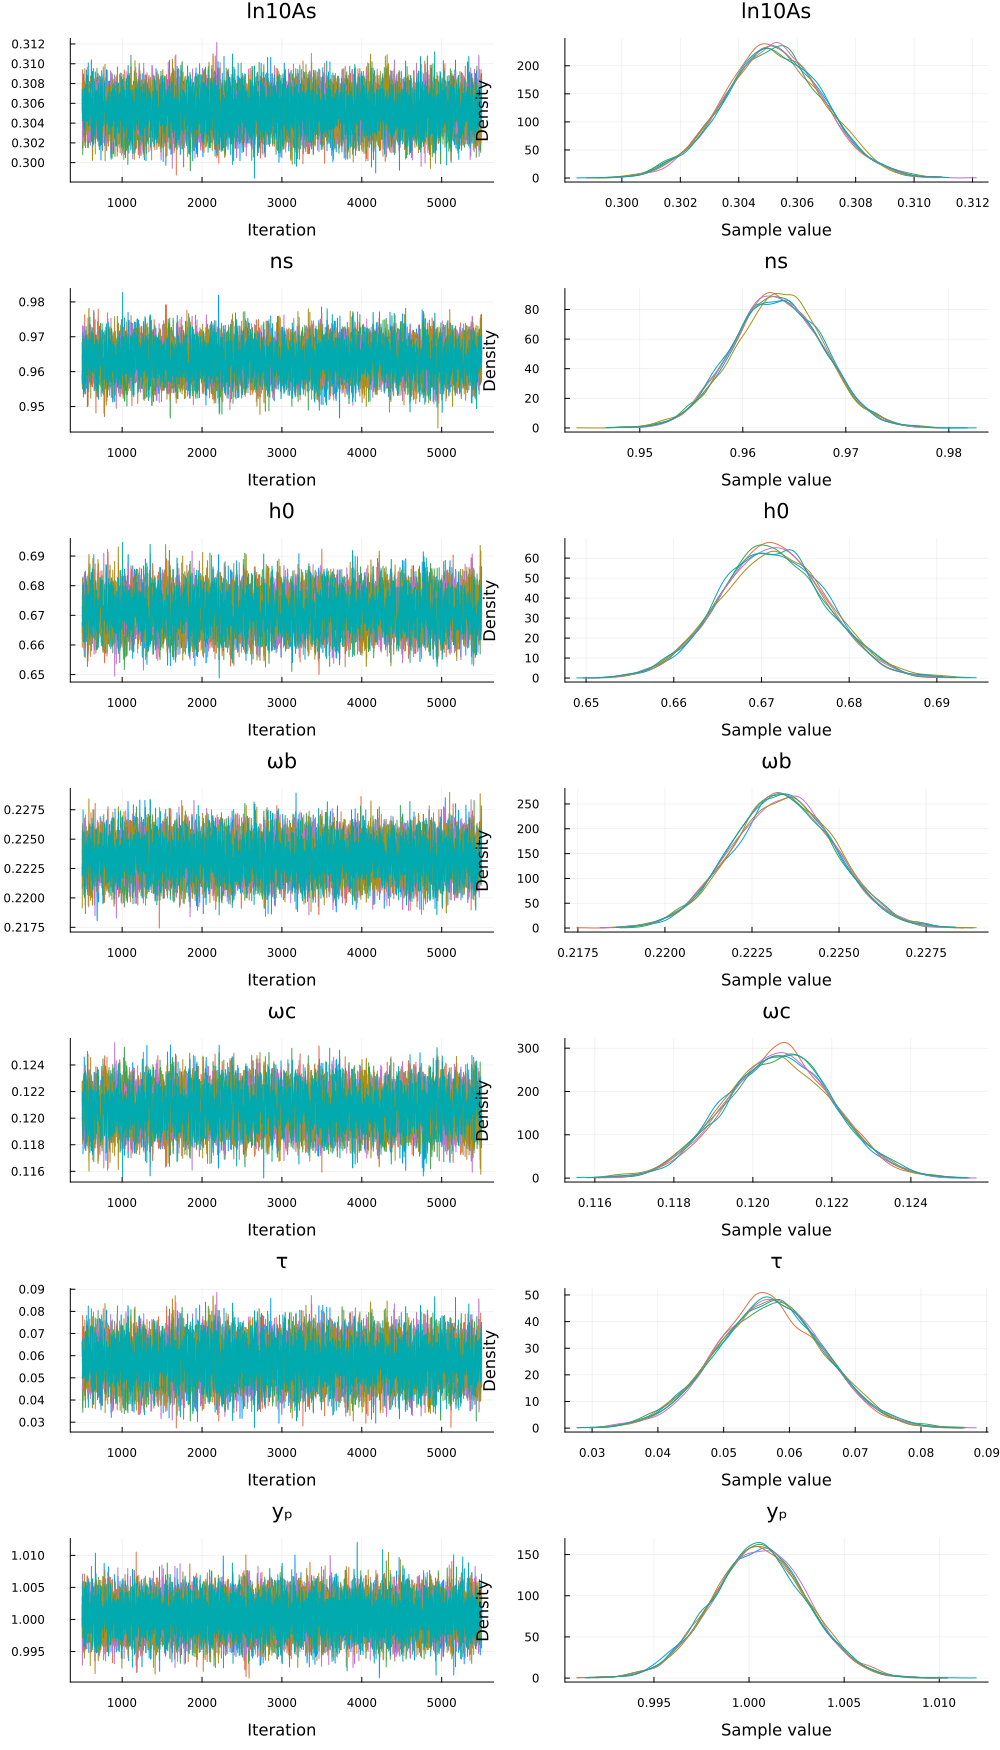

In [37]:
p = StatsPlots.plot(chains_planck_cheb_NUTS)
StatsPlots.savefig("traceplots_Planck.png")
p

In [38]:
planck_hmc_ln10As = 10 .* vec(chains_planck_cheb_NUTS["ln10As"])
planck_hmc_ns = vec(chains_planck_cheb_NUTS["ns"])
planck_hmc_H0 = 100 .* vec(chains_planck_cheb_NUTS["h0"]) 
planck_hmc_ωb = 0.1 .* vec(chains_planck_cheb_NUTS["ωb"])
planck_hmc_ωc = vec(chains_planck_cheb_NUTS["ωc"])
planck_hmc_τ = vec(chains_planck_cheb_NUTS["τ"])
planck_hmc_yₚ = vec(chains_planck_cheb_NUTS["yₚ"]);

In [39]:
CPU_s_Planck_NUTS = compute_duration(chains_planck_cheb_NUTS)
Planck_NUTS_ESS = mean(MCMCDiagnosticTools.ess_rhat(chains_planck_cheb_NUTS)[[:ln10As, :ns, :h0, :ωb,:ωc, :τ, :yₚ],:ess])
Planck_NUTS_ESS_s = Planck_NUTS_ESS/CPU_s_Planck_NUTS

69.87715170833273

In [40]:
function transpose_samples_single_chain_HMC(sample)
    save_sample = zeros(length(sample[:,1]), 7)
    for i in 1:7
        save_sample[:,i] = sample[:,i]
    end
    return save_sample
end

function combine_chains(chn)
    n_chains = length(chn.value.data[1,1,:])
    final_chain = transpose_samples_single_chain_HMC(chn.value.data[:,:,1])
    for i in 2:n_chains
        final_chain = vcat(final_chain, transpose_samples_single_chain_HMC(chn.value.data[:,:,i]))
    end
    return final_chain
end

combine_chains (generic function with 1 method)

In [41]:
npzwrite("chains_Planck_NUTS.npy", combine_chains(chains_planck_cheb_NUTS))

# MCHMC stuff

In [42]:
d = 7
target = TuringTarget(CMB_model_planck_cheb)
fol_name = "../chains/MCHMC/Planck_MCHMC_h0_cheb"
#mkdir(fol_name)
nadapts = 20_000
nsteps = 200000

spl = MCHMC(nadapts, 0.001; init_eps=0.05, L=sqrt(d),# sigma=ones(d),  #try higher init_eps
            adaptive=true)
start_mchmc = time()
@time planck_mchmc = Sample(spl, target, nsteps;
                    progress=true,
                    dialog=true, file_name="chain_1",
                    initial_x=bestfit_Planck.values.array)
end_mchmc = time()
end_mchmc - start_mchmc

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  18%|██████▌                            |  ETA: 0:00:03

Burn in step: 4000
eps --->0.0009253502350415581


MCHMC (tuning):  38%|█████████████▍                     |  ETA: 0:00:02

Burn in step: 8000
eps --->0.036099655116580975


MCHMC (tuning):  59%|████████████████████▋              |  ETA: 0:00:01

Burn in step: 12000
eps --->0.04407585388022528


MCHMC (tuning):  79%|███████████████████████████▌       |  ETA: 0:00:01

Burn in step: 16000
eps --->0.04536776051794884


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:03

Burn in step: 20000
eps --->0.0625356443841348


[ Info: eps: 0.0625356443841348
[ Info: L: 2.6457513110645907
[ Info: nu: 0.08315876826441267
[ Info: sigma: [0.07618216996115432, 0.5456072429593318, 0.5124299560559554, 0.2675677380649234, 0.17498935476784647, 0.011053045158736558, 0.004356640937844099]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:13

 21.204775 seconds (73.02 M allocations: 30.452 GiB, 16.21% gc time, 15.33% compilation time: <1% of which was recompilation)


21.223201036453247

In [43]:
n_parallel_mchmc = 8
chains = Vector{Any}(undef, n_parallel_mchmc)
vec_ess = zeros(n_parallel_mchmc)

@time for i in 1:n_parallel_mchmc
    chains[i] = Sample(MCHMC(nadapts, 0.001; init_eps=0.05, L=sqrt(d), adaptive=true), target, nsteps;
                       progress=true,
                       dialog=true, file_name="chain_1",
                       initial_x=bestfit_Planck.values.array)
    vec_ess[i] = mean(Summarize(chains[i])[1][1:7])
end

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|██████▉                            |  ETA: 0:00:01

Burn in step: 4000
eps --->0.0008444891895204777


MCHMC (tuning):  39%|█████████████▌                     |  ETA: 0:00:01

Burn in step: 8000
eps --->0.007966966857650457


MCHMC (tuning):  59%|████████████████████▊              |  ETA: 0:00:01

Burn in step: 12000
eps --->0.008179372971176662


MCHMC (tuning):  78%|███████████████████████████▍       |  ETA: 0:00:01

Burn in step: 16000
eps --->0.015922849317212915


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:03

Burn in step: 20000
eps --->0.009961819796151902


[ Info: eps: 0.009961819796151902
[ Info: L: 2.6457513110645907
[ Info: nu: 0.03286086016906432
[ Info: sigma: [0.5592244673345155, 0.3390734150733331, 0.26727329510502806, 0.48786851459296504, 0.20339524061704398, 0.07882343913946649, 0.00907251173478888]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:13[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  19%|██████▊                            |  ETA: 0:00:01

Burn in step: 4000
eps --->0.0007107787932774279


MCHMC (tuning):  38%|█████████████▍                     |  ETA: 0:00:01

Burn in step: 8000
eps --->0.025747714529179865


MCHMC (tuning):  59%|████████████████████▋              |  ETA: 0:00:01

Burn in step: 12000
eps --->0.03203102952673684


MCHMC (tuning):  78%|███████████████████████████▎       |  ETA: 0:00:01

Burn in step: 16000
eps --->0.028641171702052444


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:03

Burn in step: 20000
eps --->0.03065733674166677


[ Info: eps: 0.03065733674166677
[ Info: L: 2.6457513110645907
[ Info: nu: 0.05787349464713767
[ Info: sigma: [0.2239892727999609, 0.1922424109761278, 0.13056947653104634, 0.13967540144792717, 0.10364625976639198, 0.017988895187677368, 0.0035644593928095053]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:13[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|██████▉                            |  ETA: 0:00:01

Burn in step: 4000
eps --->0.0030435759342072456


MCHMC (tuning):  39%|█████████████▌                     |  ETA: 0:00:01

Burn in step: 8000
eps --->0.011688391451211666


MCHMC (tuning):  59%|████████████████████▊              |  ETA: 0:00:01

Burn in step: 12000
eps --->0.0040473522018375195


MCHMC (tuning):  79%|███████████████████████████▌       |  ETA: 0:00:01

Burn in step: 16000
eps --->0.009996824800379223


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:03

Burn in step: 20000
eps --->0.007565202950217644


[ Info: eps: 0.007565202950217644
[ Info: L: 2.6457513110645907
[ Info: nu: 0.028623514790820884
[ Info: sigma: [0.5605493015842713, 1.4329203729522795, 1.527570044724734, 1.0646152041543961, 2.1814576149701326, 0.03534995710370644, 0.007459763424664506]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:13[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  19%|██████▊                            |  ETA: 0:00:01

Burn in step: 4000
eps --->0.0009062938757869553


MCHMC (tuning):  39%|█████████████▌                     |  ETA: 0:00:01

Burn in step: 8000
eps --->0.07834748640543154


MCHMC (tuning):  60%|████████████████████▉              |  ETA: 0:00:01

Burn in step: 12000
eps --->0.08462248538741081


MCHMC (tuning):  79%|███████████████████████████▊       |  ETA: 0:00:01

Burn in step: 16000
eps --->0.10092851813210531


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:03

Burn in step: 20000
eps --->0.11176300733081637


[ Info: eps: 0.11176300733081637
[ Info: L: 2.6457513110645907
[ Info: nu: 0.1122219768430085
[ Info: sigma: [0.07376906029382484, 0.10734748708712809, 0.19058735231607898, 0.13722955652707725, 0.06882766298885999, 0.008932427938093521, 0.0026975145071324092]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:13[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  19%|██████▊                            |  ETA: 0:00:01

Burn in step: 4000
eps --->0.0008824619665411267


MCHMC (tuning):  38%|█████████████▍                     |  ETA: 0:00:01

Burn in step: 8000
eps --->0.028515712050823424


MCHMC (tuning):  59%|████████████████████▋              |  ETA: 0:00:01

Burn in step: 12000
eps --->0.03532884653576135


MCHMC (tuning):  79%|███████████████████████████▌       |  ETA: 0:00:01

Burn in step: 16000
eps --->0.034231490033141264


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:03

Burn in step: 20000
eps --->0.031729847014231344


[ Info: eps: 0.031729847014231344
[ Info: L: 2.6457513110645907
[ Info: nu: 0.05888909168652356
[ Info: sigma: [0.24382995788994205, 0.34707528665958554, 0.35039945959769053, 0.7310959409547482, 0.1384874455060902, 0.01496881891455037, 0.012057122567280462]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:13[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  19%|██████▊                            |  ETA: 0:00:01

Burn in step: 4000
eps --->0.0010287608539148033


MCHMC (tuning):  38%|█████████████▎                     |  ETA: 0:00:01

Burn in step: 8000
eps --->0.030571077200637255


MCHMC (tuning):  58%|████████████████████▌              |  ETA: 0:00:01

Burn in step: 12000
eps --->0.03285826492560798


MCHMC (tuning):  78%|███████████████████████████▎       |  ETA: 0:00:01

Burn in step: 16000
eps --->0.05893796805589748


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:03

Burn in step: 20000
eps --->0.05746275323212649


[ Info: eps: 0.05746275323212649
[ Info: L: 2.6457513110645907
[ Info: nu: 0.07963756073956149
[ Info: sigma: [0.08776829270257627, 0.2287523517012052, 0.3680176326423914, 0.1711248079119798, 0.16786219565457705, 0.010758168629621274, 0.0025473532936210333]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:13[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  19%|██████▊                            |  ETA: 0:00:01

Burn in step: 4000
eps --->0.0008839852666983477


MCHMC (tuning):  38%|█████████████▎                     |  ETA: 0:00:01

Burn in step: 8000
eps --->0.009213940709980972


MCHMC (tuning):  59%|████████████████████▌              |  ETA: 0:00:01

Burn in step: 12000
eps --->0.01260629573598909


MCHMC (tuning):  78%|███████████████████████████▍       |  ETA: 0:00:01

Burn in step: 16000
eps --->0.014176468184211229


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:03

Burn in step: 20000
eps --->0.013345174920456714


[ Info: eps: 0.013345174920456714
[ Info: L: 2.6457513110645907
[ Info: nu: 0.03805833766850871
[ Info: sigma: [0.6824021750098116, 0.17950172540809378, 0.6786113419924651, 0.18517147607539464, 0.3689543708842159, 0.038973117486171216, 0.006164341979862758]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:13[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:00:01

Burn in step: 4000
eps --->0.0010493925742360707


MCHMC (tuning):  39%|█████████████▌                     |  ETA: 0:00:01

Burn in step: 8000
eps --->0.022767180861889225


MCHMC (tuning):  59%|████████████████████▋              |  ETA: 0:00:01

Burn in step: 12000
eps --->0.03487195313539137


MCHMC (tuning):  78%|███████████████████████████▍       |  ETA: 0:00:01

Burn in step: 16000
eps --->0.046067942269343305


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:03

Burn in step: 20000
eps --->0.04874624886425237


[ Info: eps: 0.04874624886425237
[ Info: L: 2.6457513110645907
[ Info: nu: 0.07322765900829092
[ Info: sigma: [0.11458139808455754, 0.14321647194815693, 0.3293866819877028, 0.2997551544934606, 0.1828189707592369, 0.01769866827326725, 0.004813120487413841]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:12

151.780413 seconds (536.38 M allocations: 288.406 GiB, 19.62% gc time)


In [44]:
_chains = zeros(200000, 2, 7)
_chains[:,1,:] = mapreduce(permutedims, vcat, chains[1])[:,1:7]
_chains[:,2,:] = mapreduce(permutedims, vcat, chains[2])[:,1:7]

200000×7 Matrix{Float64}:
 0.304901  0.96306   0.666684  0.221441  0.121282  0.0583072  0.996262
 0.304965  0.96318   0.666701  0.22145   0.121328  0.0584577  0.996207
 0.304965  0.963283  0.666728  0.221458  0.121378  0.0587524  0.99616
 0.304899  0.963359  0.666741  0.221461  0.121426  0.0591089  0.996137
 0.304819  0.963407  0.666752  0.221468  0.121468  0.0594926  0.996117
 0.304741  0.963449  0.666746  0.221483  0.121503  0.0598914  0.996097
 0.304704  0.96351   0.666739  0.221505  0.121544  0.0602836  0.996071
 0.304734  0.963611  0.666727  0.221528  0.121583  0.0606047  0.996028
 0.304833  0.963706  0.6667    0.221552  0.121617  0.0607407  0.995984
 0.304969  0.963778  0.666666  0.221572  0.121635  0.060702   0.995946
 0.305117  0.963837  0.666632  0.221583  0.121643  0.0605935  0.995906
 0.305266  0.963868  0.666584  0.221592  0.121651  0.0604968  0.995863
 0.305401  0.963928  0.666519  0.221609  0.121648  0.0604737  0.995817
 ⋮                                                 ⋮

In [45]:
MCMCDiagnosticTools.ess_rhat(_chains)

([6303.795711124453, 2725.5755334725395, 1723.4942227196727, 2703.125626118574, 1866.2538278273814, 6424.728024882837, 4022.69013392404], [1.0000733169435885, 1.0002679548106705, 1.0002895154347833, 1.000187295369357, 1.0002633946676824, 1.0000640348639407, 1.00042169102318])

In [46]:
Summarize(planck_mchmc)

([1456.3231875734964, 7303.824777339891, 4142.211671196106, 4407.791238392585, 4794.56958660506, 1494.8513927104134, 3380.75425858856, 1514.2461835422578, 210528.66456652843, 10216.72546526754], [1.0002451502160674, 1.0000261309535803, 1.0000976620266124, 1.0003342602993681, 1.0000455425535155, 1.0003398679259516, 1.0000231153476582, 1.0030985556130279, 0.9999950019013137, 1.0000259028416707])

In [47]:
x = [mapreduce(permutedims, vcat, chains[i]) for i in 1:n_parallel_mchmc];

In [48]:
planck_mchmc_ln10As_multi = 10 .* extract_single(x, 1, n_parallel_mchmc)
planck_mchmc_ns_multi = extract_single(x, 2, n_parallel_mchmc)
planck_mchmc_H0_multi = 100 .* extract_single(x, 3, n_parallel_mchmc)
planck_mchmc_ωb_multi = 0.1 .* extract_single(x, 4, n_parallel_mchmc)
planck_mchmc_ωc_multi = extract_single(x, 5, n_parallel_mchmc)
planck_mchmc_τ_multi = extract_single(x, 6, n_parallel_mchmc)
planck_mchmc_yₚ_multi = extract_single(x, 7, n_parallel_mchmc);

ciccio = zeros(nsteps*n_parallel_mchmc, 7)
for i in 1:7
    ciccio[:,i] = extract_single(x, i, n_parallel_mchmc)
end

In [49]:
vec_ess

8-element Vector{Float64}:
 1901.6080386548342
 1793.2514199070663
 1971.8769684909068
 2591.60478127413
 3839.343938057086
 2980.950959630985
 1487.8384055446863
 3035.000858605993

In [50]:
planck_mchmc_parallel_ess_s = sum(vec_ess)/(n_parallel_mchmc*(end_mchmc - start_mchmc))

115.44839145905662

In [51]:
_planck_mchmc = mapreduce(permutedims, vcat, planck_mchmc)
E = _planck_mchmc[:, end-1]
std(E).^2/d

0.0010297057986679175

In [52]:
npzwrite("chains_planck_mchmc.npy", _planck_mchmc)
npzwrite("chains_planck_mchmc_multi.npy", ciccio)

In [53]:
planck_mchmc_ess = mean(Summarize(planck_mchmc)[1][1:7])
planck_mchmc_ess_logp = planck_mchmc_ess/nsteps
planck_mchmc_ess_s = planck_mchmc_ess/28

137.65472506329647